# This Notebook performs RAG on Soft Bank's annual report for financial year 2019

In [2]:
import os
from unstructured.partition.pdf import partition_pdf
import pytesseract
import uuid

from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.schema.document import Document
from langchain.storage import InMemoryStore
from langchain.vectorstores import Chroma

import base64
from langchain.chat_models import ChatOpenAI
from langchain.schema.messages import HumanMessage, AIMessage
from dotenv import load_dotenv

from langchain.schema.runnable import RunnablePassthrough
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser

load_dotenv()

/home/adarsh/multimodel/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [3]:
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

# Extracting Images, Texts and Tables from PDF

In [4]:
input_path = os.getcwd()
output_path = os.path.join(os.getcwd(), "figures")

raw_pdf_elements = partition_pdf(
    filename=os.path.join(input_path, "annual-report_fy2019_02_en.pdf"),
    extract_images_in_pdf=True,
    strategy="hi_res",
    hi_res_model_name="yolox",
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=5000,
    new_after_n_chars=4800,
    combine_text_under_n_chars=3000,
    image_output_dir_path=output_path,
)

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [6]:
raw_pdf_elements

In [7]:
text_elements = []
table_elements = []
image_elements = []

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

for element in raw_pdf_elements:
    if 'CompositeElement' in str(type(element)):
        text_elements.append(element)
    elif 'Table' in str(type(element)):
        table_elements.append(element)

table_elements = [i.text for i in table_elements]
text_elements = [i.text for i in text_elements]

# Tables
print("The length of table elements are :", len(table_elements))

# Text
print("The length of text elements are :", len(text_elements))

for image_file in os.listdir(output_path):
    if image_file.endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(output_path, image_file)
        encoded_image = encode_image(image_path)
        image_elements.append(encoded_image)
        
# image
print("The length of image elements are :",len(image_elements))

The length of table elements are : 4
The length of text elements are : 239
The length of image elements are : 143


# Applying Semantic Chunking:

In [70]:
from langchain_experimental.text_splitter import SemanticChunker
chunker = SemanticChunker(OpenAIEmbeddings(), breakpoint_threshold_type="percentile")

In [72]:
text_elements = [chunker.split_text(text) for text in text_elements]

In [74]:
text_elements = [item for sublist in text_elements for item in (sublist if isinstance(sublist, list) else [sublist])]

In [8]:
model = ChatOpenAI(model="gpt-4o")

/tmp/ipykernel_26638/1935995792.py:1: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  model = ChatOpenAI(model="gpt-4o")


In [9]:
def summarize_image(encoded_image):
    prompt = [
        AIMessage(content="You are a bot that is good at analyzing images."),
        HumanMessage(content=[
            {"type": "text", "text": "Describe the contents of this image."},
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{encoded_image}"
                },
            },
        ])
    ]
    response = model.invoke(prompt)
    return response.content

In [12]:
image_summaries=[summarize_image(i) for i in image_elements]

# Creating Milvus vector store

In [13]:
from langchain_openai import OpenAIEmbeddings
from langchain_milvus import Milvus
from langchain.storage import InMemoryStore
from langchain.retrievers.multi_vector import MultiVectorRetriever

### Creating vector stores using Flat indexing, IVF and Auto Index. (HNSW not supported in Milvus)

In [82]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

vectorstore = Milvus(
    embedding_function=embeddings,
    connection_args={"uri": "./milvus_example.db"},
    collection_name="summaris",
    index_params={"index_type": "FLAT", "metric_type": "L2"},
)

2025-06-04 15:02:11,947 [DEBUG][_create_connection]: Created new connection using: 288f2b20ba9740a7ab982bdc1ca36efc (async_milvus_client.py:599)


In [57]:
vectorstore_auto_index = Milvus(
    embedding_function=embeddings,
    connection_args={"uri": "./milvus_example.db"},
    collection_name="summaris_AUTOINDEX",
    index_params={"index_type": "AUTOINDEX", "metric_type": "L2"},
)

vectorstore_ivf = Milvus(
    embedding_function=embeddings,
    connection_args={"uri": "./milvus_example.db"},
    collection_name="summaris_IVF",
    index_params={"index_type": "IVF_FLAT", "metric_type": "L2"},
)

2025-06-04 08:04:02,988 [DEBUG][_create_connection]: Created new connection using: 27ab459c09584500958a5ab589c80baa (async_milvus_client.py:599)
2025-06-04 08:04:03,007 [DEBUG][_create_connection]: Created new connection using: 3e6c2b41652a4978a09ab7b6b40d682d (async_milvus_client.py:599)


In [58]:
store = InMemoryStore()
id_key = "doc_id"
retriever = MultiVectorRetriever(vectorstore=vectorstore, docstore=store, id_key=id_key, top_k=1)
retriever_auto_index = MultiVectorRetriever(vectorstore=vectorstore_auto_index, docstore=store, id_key=id_key, top_k=1)
retriever_ivf = MultiVectorRetriever(vectorstore=vectorstore_ivf, docstore=store, id_key=id_key, top_k=1)

In [ ]:
def add_documents_to_retriever(summaries, original_contents):
    doc_ids = [str(uuid.uuid4()) for _ in summaries]
    summary_docs = [
        Document(page_content=s, metadata={id_key: doc_ids[i]})
        for i, s in enumerate(summaries)
    ]
    retriever.vectorstore.add_documents(summary_docs)
    retriever.docstore.mset(list(zip(doc_ids, original_contents)))
    retriever_auto_index.vectorstore.add_documents(summary_docs)
    retriever_auto_index.docstore.mset(list(zip(doc_ids, original_contents)))
    retriever_ivf.vectorstore.add_documents(summary_docs)
    retriever_ivf.docstore.mset(list(zip(doc_ids, original_contents)))

In [85]:
add_documents_to_retriever(text_elements, text_elements)


add_documents_to_retriever(table_elements, table_elements)


add_documents_to_retriever(image_summaries, image_elements) 

/home/adarsh/multimodel/.venv/lib/python3.12/site-packages/langchain_milvus/vectorstores/milvus.py:1141: UserWarning: No ids provided and auto_id is False. Setting auto_id to True automatically.
  warnings.warn(


In [101]:
template = """Answer the question based only on the following context, which can include text, images and tables:
{context}
Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

chain_flat = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

chain_ivf = (
    {"context": retriever_ivf, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

chain_auto_index = (
    {"context": retriever_auto_index, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

In [102]:
import time

def run_chain_with_timing(chain, question: str):
    start_time = time.time()
    
    result = chain.invoke(question)
    
    end_time = time.time()
    duration = end_time - start_time

    return result, duration

In [116]:
def scored_retrieval(question: str, vectorstore):
    docs_with_scores = vectorstore.similarity_search_with_score(question, k=3)
    return [
        (score ,doc.page_content) for doc, score in docs_with_scores
    ]

In [150]:
from docx import Document

def write_to_docx(text, file_path="output.docx"):
    doc = Document()
    doc.add_heading("Generated Answer", level=1)
    doc.add_paragraph(text)
    doc.save(file_path)

### Comparing time taken for each indexing mechanism

In [ ]:
# Flat indexing
result, duration = run_chain_with_timing(chain_flat, "Income before income tax in financial year 2018")
print('result : ',result)
print('duration : ',duration)

result :  Income before income tax in financial year 2018 was ¥1,691,302 million, which represented an increase of ¥1,306,672 million (339.7%) year on year.
duration :  13.411423683166504


In [ ]:
# Ivf indexing
result, duration = run_chain_with_timing(chain_ivf, "Income before income tax in financial year 2018")
print('result : ',result)
print('duration : ',duration)

result :  Income before income tax for the financial year 2018 was ¥1,691,302 million.
duration :  5.890115022659302


In [ ]:
# Auto indexing (HNSW not supported in Milvus)
result, duration = run_chain_with_timing(chain_auto_index, "Income before income tax in financial year 2018")
print('result : ',result)
print('duration : ',duration)

result :  In the financial year 2018, the income before income tax increased by ¥1,306,672 million (339.7%) year on year, reaching a total of ¥1,691,302 million.
duration :  6.545596599578857


### IVF indexing is faster compared to all other indexing mechanisms


In [ ]:
import pprint

In [144]:
question1= "Income before income tax in financial year 2018"
answer1 = chain_ivf.invoke(question1)
print(answer1)

The income before income tax in the financial year 2018 was ¥1,691,302 million, which represented an increase of ¥1,306,672 million (339.7%) year on year.


In [ ]:
# Validating output
docs_with_score = scored_retrieval("Income before income tax in financial year 2018", vectorstore_ivf)
docs_with_score

[(1.036613941192627, '3. Income before Income Tax\n\nIncome before income tax increased ¥1,306,672 million (339.7%) year on year, to ¥1,691,302 million.\n\nFinance cost increased ¥117,637 million (22.8%) year on year, to ¥633,769 million. Interest expenses increased ¥45,544 million at SoftBank Group Corp.3 This was mainly due to an increase in interest-bearing debt associated with the issuance of foreign currency-denominated senior notes in September 2017 and the borrowings made by a wholly owned subsidiary of the Company using Alibaba shares. The Company also recognized ¥24,051 million in conjunction with the partial repayment of a senior loan, as a result of the full amortization of the unamortized balance of an amortized cost. In addition, the interest expenses of SoftBank Vision Fund increased ¥25,339 million due to borrowings made using NVIDIA shares.\n\n(Millions of yen)\n\nFiscal 2017 Fiscal 2018 Change (516,132) (633,769) (117,637) SoftBank Group Corp.3 . . . . . . . . . . . . 

In [135]:
pprint.pprint(docs_with_score[0][1])

('3. Income before Income Tax\n'
 '\n'
 'Income before income tax increased ¥1,306,672 million (339.7%) year on year, '
 'to ¥1,691,302 million.\n'
 '\n'
 'Finance cost increased ¥117,637 million (22.8%) year on year, to ¥633,769 '
 'million. Interest expenses increased ¥45,544 million at SoftBank Group '
 'Corp.3 This was mainly due to an increase in interest-bearing debt '
 'associated with the issuance of foreign currency-denominated senior notes in '
 'September 2017 and the borrowings made by a wholly owned subsidiary of the '
 'Company using Alibaba shares. The Company also recognized ¥24,051 million in '
 'conjunction with the partial repayment of a senior loan, as a result of the '
 'full amortization of the unamortized balance of an amortized cost. In '
 'addition, the interest expenses of SoftBank Vision Fund increased ¥25,339 '
 'million due to borrowings made using NVIDIA shares.\n'
 '\n'
 '(Millions of yen)\n'
 '\n'
 'Fiscal 2017 Fiscal 2018 Change (516,132) (633,769) (117

In [151]:
# Writing question1 and corresponding answer with context to docs file
text = f"""
Question : {question1}  \n\n
Answer   : {answer1} \n\n
Context  : {docs_with_score[0][1]}
"""
write_to_docx(text, file_path="output_question1.docx")

### Reranking using Bm25

In [121]:
# Top 3 ranked docs:
ranked_docs = [i[1] for i in docs_with_score]
ranked_docs

['3. Income before Income Tax\n\nIncome before income tax increased ¥1,306,672 million (339.7%) year on year, to ¥1,691,302 million.\n\nFinance cost increased ¥117,637 million (22.8%) year on year, to ¥633,769 million. Interest expenses increased ¥45,544 million at SoftBank Group Corp.3 This was mainly due to an increase in interest-bearing debt associated with the issuance of foreign currency-denominated senior notes in September 2017 and the borrowings made by a wholly owned subsidiary of the Company using Alibaba shares. The Company also recognized ¥24,051 million in conjunction with the partial repayment of a senior loan, as a result of the full amortization of the unamortized balance of an amortized cost. In addition, the interest expenses of SoftBank Vision Fund increased ¥25,339 million due to borrowings made using NVIDIA shares.\n\n(Millions of yen)\n\nFiscal 2017 Fiscal 2018 Change (516,132) (633,769) (117,637) SoftBank Group Corp.3 . . . . . . . . . . . . . . . . . . . . . . 

In [123]:
tokenized_ranked_documents = [doc.split() for doc in ranked_docs]

In [124]:
tokenized_ranked_documents

[['3.', 'Income', 'before', 'Income', 'Tax', 'Income', 'before', 'income', 'tax', 'increased', '¥1,306,672', 'million', '(339.7%)', 'year', 'on', 'year,', 'to', '¥1,691,302', 'million.', 'Finance', 'cost', 'increased', '¥117,637', 'million', '(22.8%)', 'year', 'on', 'year,', 'to', '¥633,769', 'million.', 'Interest', 'expenses', 'increased', '¥45,544', 'million', 'at', 'SoftBank', 'Group', 'Corp.3', 'This', 'was', 'mainly', 'due', 'to', 'an', 'increase', 'in', 'interest-bearing', 'debt', 'associated', 'with', 'the', 'issuance', 'of', 'foreign', 'currency-denominated', 'senior', 'notes', 'in', 'September', '2017', 'and', 'the', 'borrowings', 'made', 'by', 'a', 'wholly', 'owned', 'subsidiary', 'of', 'the', 'Company', 'using', 'Alibaba', 'shares.', 'The', 'Company', 'also', 'recognized', '¥24,051', 'million', 'in', 'conjunction', 'with', 'the', 'partial', 'repayment', 'of', 'a', 'senior', 'loan,', 'as', 'a', 'result', 'of', 'the', 'full', 'amortization', 'of', 'the', 'unamortized', 'balanc

In [125]:
query = "Income before income tax in financial year 2018"
tokenized_query = query.split()
tokenized_query

['Income', 'before', 'income', 'tax', 'in', 'financial', 'year', '2018']

In [127]:
from rank_bm25 import BM25Okapi

In [128]:
bm25=BM25Okapi(tokenized_ranked_documents)

In [130]:
bm25_scores = bm25.get_scores(tokenized_query)
bm25_scores

array([-1.46146774, -1.46146774, -1.10029864])

In [131]:
import numpy as np

In [132]:
sorted_indices = np.argsort(bm25_scores)[::-1]
sorted_indices

array([2, 1, 0])

In [133]:
reranked_documents = [(ranked_docs[i], bm25_scores[i]) for i in sorted_indices]
reranked_documents

[('The image is a bar chart showing the income before income tax for a company from fiscal years 2009 to 2018, measured in billions of yen. \n\n- The chart is divided into two accounting standards: JGAAP (FY09-FY11) and IFRSs (FY12-FY18).\n- The light blue bars represent total income before income tax, while the darker blue segments within FY17 and FY18 indicate income from the SoftBank Vision Fund and Delta Fund.\n- Income increases over time, with notable growth in FY18, reaching 1,691.3 billion yen, of which 814.6 billion yen is from the Vision and Delta Funds.\n- There is a substantial growth of +339.7% in FY18 compared to previous years.', np.float64(-1.1002986350260386)), ('3. Income before Income Tax\n\nIncome before income tax increased ¥1,306,672 million (339.7%) year on year, to ¥1,691,302 million.\n\nFinance cost increased ¥117,637 million (22.8%) year on year, to ¥633,769 million. Interest expenses increased ¥45,544 million at SoftBank Group Corp.3 This was mainly due to an

In [39]:
import base64
from PIL import Image
from io import BytesIO
import IPython.display as display

def display_encoded_image(encoded_string):
    image_data = base64.b64decode(encoded_string)
    image = Image.open(BytesIO(image_data))
    display.display(image)

## Analyzing result from image embedding

In [152]:
question2= "percentage of share softbank has in T-mobile US"
answer2 = chain_flat.invoke(question2)
print(answer2)

SoftBank holds approximately 27.4% of the shares in T-Mobile US, Inc. after the merger transactions.


In [153]:
docs_with_score = scored_retrieval(question2, vectorstore_ivf)
docs_with_score

[(0.7187557220458984, 'The image is a diagram illustrating the ownership structure of T-Mobile US, Inc. ("New T-Mobile") following a merger. The structure is as follows:\n\n- **Deutsche Telekom AG** owns 41.7% of T-Mobile US, Inc.\n- **SoftBank Group Corp.** owns 27.4%.\n- **Former Sprint Public** shareholders own 5.6%.\n- **Former T-Mobile Public** shareholders own 25.3%.\n\nT-Mobile US, Inc. is linked to "Huron Merger Sub LLC" ("T-Mobile Merger Co.") and then to "Sprint Corporation."\n\nThe diagram uses lines to represent beneficial ownership.'), (0.718782901763916, 'The image is a diagram illustrating the ownership structure of T-Mobile US, Inc. ("New T-Mobile") following a merger. The structure is as follows:\n\n- **Deutsche Telekom AG** owns 41.7% of T-Mobile US, Inc.\n- **SoftBank Group Corp.** owns 27.4%.\n- **Former Sprint Public** shareholders own 5.6%.\n- **Former T-Mobile Public** shareholders own 25.3%.\n\nT-Mobile US, Inc. is linked to "Huron Merger Sub LLC" ("T-Mobile Mer

In [154]:
# Validating output
ret = chain_flat.first
contexts=ret.invoke(question2)["context"]
contexts

['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAIIA8UDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD1/wC2eMP+gFof/g5m/wDkWj7Z4w/6AWh/+Dmb/wCRa6CigDn/ALZ4w/6AWh/+Dmb/AORaPtnjD/oBaH/4OZv/AJFroKKAOf8AtnjD/oBaH/4OZv8A5Fo+2eMP+gFof/g5m/8AkWugooA5/wC2eMP+gFof/g5m/wDkWj7Z4w

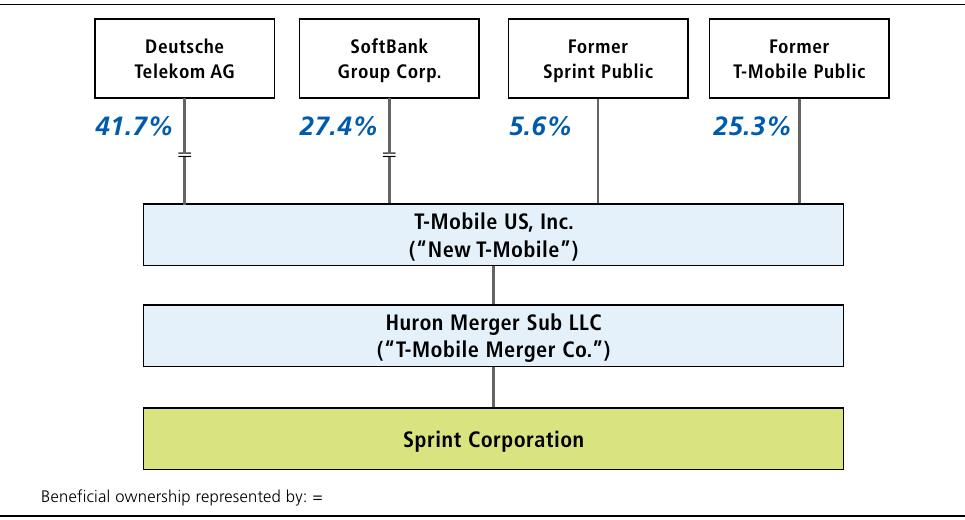

In [155]:
display_encoded_image(contexts[0])

In [157]:
# Writing question2 and corresponding answer with context to docs file
text = f"""
Question : {question2}  \n\n
Answer   : {answer2} \n\n
Context_summary  : {docs_with_score[0][1]} \n\n
Context : {contexts[0]} \n\n
"""
write_to_docx(text, file_path="output_question2.docx")

## Analyzing result from table embedding data:

In [171]:
question3= "date of maturity for 54th Unsecured Straight Bond."
answer3 = chain_ivf.invoke(question3)
pprint.pprint(answer3)

'The date of maturity for the 54th Unsecured Straight Bond is June 12, 2024.'


In [172]:
# Validating output
docs_with_score = scored_retrieval(question3, vectorstore_ivf)
docs_with_score

[(0.9638047814369202, 'Company name / Name of bond oftBank Group Corp. 43rd Unsecured Straight Bond. ..............0.208 Date of issuance Jun. 20, 2013 amount® ¥ - (Millions of yen)’ ¥ 399,831 (Millions of yen)’ ¥ - (Thousands of U.S. dollars)’ $ - Interest rate (%) 1.74 Date of maturity Jun. 20, 2018 44th Unsecured Straight Bond.................... 45th Unsecured Straight Bond..................0. Nov. 29, 2013 ¥ 50,000 million (399,831) 49,915 49,950 450,040 1.69 Nov. 27, 2020 May 30, 2014 ¥300,000 million 299,160 299,935 2,702,361 1.45 May 30, 2019 (299,935) (2,702,361) 46th Unsecured Straight Bond. .........0....0.208 Sep. 12, 2014 ¥400,000 million 398,548 399,573 3,600,081 1.26 Sep. 12, 2019 (399,573) (3,600,081) 47th Unsecured Straight Bond Jun. 18, 2015 ¥100,000 million 99,438 99,697 898,251 1.36 Jun. 18, 2020 48th Unsecured Straight Bond. . Dec. 10, 2015 ¥370,000 million 366,870 367,541 3,311,479 2.13 Dec. 9, 2022 49th Unsecured Straight Bond Apr. 20, 2016 ¥ 20,000 million 19,93

In [174]:
pprint.pprint(docs_with_score[0][1])

('Company name / Name of bond oftBank Group Corp. 43rd Unsecured Straight '
 'Bond. ..............0.208 Date of issuance Jun. 20, 2013 amount® ¥ - '
 '(Millions of yen)’ ¥ 399,831 (Millions of yen)’ ¥ - (Thousands of U.S. '
 'dollars)’ $ - Interest rate (%) 1.74 Date of maturity Jun. 20, 2018 44th '
 'Unsecured Straight Bond.................... 45th Unsecured Straight '
 'Bond..................0. Nov. 29, 2013 ¥ 50,000 million (399,831) 49,915 '
 '49,950 450,040 1.69 Nov. 27, 2020 May 30, 2014 ¥300,000 million 299,160 '
 '299,935 2,702,361 1.45 May 30, 2019 (299,935) (2,702,361) 46th Unsecured '
 'Straight Bond. .........0....0.208 Sep. 12, 2014 ¥400,000 million 398,548 '
 '399,573 3,600,081 1.26 Sep. 12, 2019 (399,573) (3,600,081) 47th Unsecured '
 'Straight Bond Jun. 18, 2015 ¥100,000 million 99,438 99,697 898,251 1.36 Jun. '
 '18, 2020 48th Unsecured Straight Bond. . Dec. 10, 2015 ¥370,000 million '
 '366,870 367,541 3,311,479 2.13 Dec. 9, 2022 49th Unsecured Straight Bond '
 'Apr. 

In [175]:
# Writing question3 and corresponding answer with context to docs file
text = f"""
Question : {question3}  \n\n
Answer   : {answer3} \n\n
Context : {docs_with_score[0][1]} \n\n
"""
write_to_docx(text, file_path="output_question3.docx")